# Introduction

<br>

## Shopee Code League - Sentiment Analysis

<br>

### Background
At Shopee, we always strive to ensure the customer’s highest satisfaction. Whatever product is sold on Shopee, we ensure the best user experience starting from product searching to product delivery, including product packaging, and product quality. Once a product is delivered, we always encourage our customer to rate the product and write their overall experience on the product landing page.
The rating and comments provided for a product by our buyers are most important to us. These product reviews help us to understand our customers needs and quickly adapt our services to provide a much better experience for our customers for the next order. The user's comments for a product ranges from aspects including delivery services, product packaging, product quality, product specifications, payment method, etc. Therefore it is important for us to build an accurate system to understand these reviews which has a great impact on overall Shopee’s user experience. This system is termed: "Shopee Product Review Sentiment Analyser".

<br>

### Task
In this competition, a multiple product review sentiment classification model needs to be built. There are ~150k product reviews from different categories, including electronics, furniture, home & living products like air-conditioner and fashion products like T-shirts, rings, etc. For data security purposes, the review ids will be desensitized. The evaluation metrics is top-1 accuracy.

<br>

### Evaluation metric
\begin{equation}
{score = \frac{1}{N}\sum_{i=0}^{N}p(x_{i}, y_{i})}
\end{equation}

Where

- $N$ is number of test samples.

- $x_{i}$ is the predicted category for $i$ th test sample.

- $y_{i}$ is the ground truth for $i$ th test sample.

- $p(x_{i}, y_{i})$ is calculated as 1 if $x_{i}$=$y_{i}$ and 0 otherwise.

# Import libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set('talk')
sns.set_style('white')

import re
import emoji

# Load data

In [2]:
# Original train data
original_train_df = pd.read_csv('../input/shopee-sentiment-analysis/train.csv')

# Additional scrapped data from shopee website
scrapped_train_df = pd.read_csv('../input/shopee-reviews/shopee_reviews.csv').rename(columns={'label': 'rating', 'text': 'review'})
scrapped_train_df = scrapped_train_df[scrapped_train_df['rating'] != 'label']
scrapped_train_df['rating'] = scrapped_train_df['rating'].astype(int)

# Extended old train data
extended_train_df = pd.read_csv('../input/test-labelled/test_labelled.csv')

# Combine into train
train_df = pd.concat([original_train_df, scrapped_train_df, extended_train_df], axis=0).reset_index(drop=True)
train_df['review_id'] = train_df.index

# Test data
test_df = pd.read_csv('../input/shopee-sentiment-analysis/test.csv')

print('Shape of train: {}'.format(train_df.shape))
print('Shape of test: {}'.format(test_df.shape))
print('\nTrain info:')
train_df.info()
print('\nTest info:')
test_df.info()

Shape of train: (1712303, 3)
Shape of test: (60427, 2)

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712303 entries, 0 to 1712302
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   review_id  int64 
 1   review     object
 2   rating     int64 
dtypes: int64(2), object(1)
memory usage: 39.2+ MB

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60427 entries, 0 to 60426
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  60427 non-null  int64 
 1   review     60427 non-null  object
dtypes: int64(1), object(1)
memory usage: 944.3+ KB


# Exploratory Data Analysis

In [3]:
train_df.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [4]:
test_df.head()

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


1    0.028894
2    0.021740
3    0.058650
4    0.094572
5    0.796144
Name: rating, dtype: float64

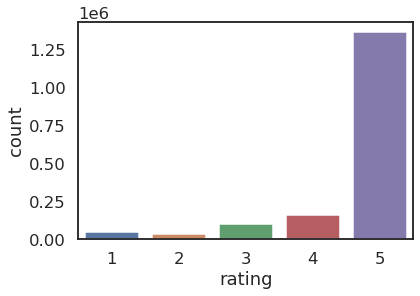

In [5]:
# Check the distribution of ratings
display(train_df['rating'].value_counts(normalize=True).sort_index())
sns.countplot(x='rating', data=train_df);

1    0.055319
2    0.041623
3    0.112289
4    0.181064
5    0.609705
Name: rating, dtype: float64

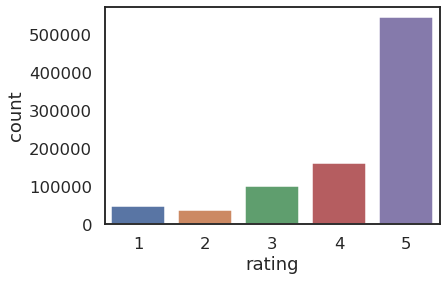

In [6]:
# Downsample rating of 5 while reducing size of train data
train_df = train_df.drop(train_df[train_df['rating'] == 5].sample(frac=0.6, random_state=42).index)
display(train_df['rating'].value_counts(normalize=True).sort_index())
sns.countplot(x='rating', data=train_df);

In [7]:
# Check is there emojis in the reviews
train_emoji_row_count = 0
test_emoji_row_count = 0

for review in train_df['review']:
    for char in review:
        if char in emoji.UNICODE_EMOJI:
            train_emoji_row_count += 1
            break

for review in test_df['review']:
    for char in review:
        if char in emoji.UNICODE_EMOJI:
            test_emoji_row_count += 1
            break
            
print('{:.2f}% of rows in train has emojis'.format(100*train_emoji_row_count/len(train_df)))
print('{:.2f}% of rows in test has emojis'.format(100*test_emoji_row_count/len(test_df)))

8.80% of rows in train has emojis
12.55% of rows in test has emojis


# Data cleaning

Since there are sizeable number of emojis in the training and testing data, it is not logical to totally remove them as emojis play an essential part in sentiment analysis. Emojis can be converted to words using demojize.

In [8]:
print('Before:')
train_df.loc[70266, 'review']

Before:


'Excellent, Satisfied, Good Packaging, Recommended & Nice... 😊😊😊😊 😎😎😎😎'

Another problem is when there are many repeated emojis in a single review, so only unique emojis should be kept. Repeated words from demojize should be removed.

In [9]:
print('After:')
emoji.demojize(train_df.loc[70266, 'review'])

After:


'Excellent, Satisfied, Good Packaging, Recommended & Nice... :smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes: :smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses:'

The reviews are user generated texts so they often contains repeated letters (especially in bahasa indonesia). These repeated letters should be removed however, in English, there are words with repeated letters such as 'less' or 'good'. The easy solution is to only remove characters that are repeated more than 2 times.

In [10]:
print('Before:')
train_df.loc[92129, 'review'].lower()

Before:


'ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt'

In [11]:
print('After:')
re.sub(r'(\w)\1{2,}', r'\1', train_df.loc[92129, 'review'].lower())

After:


'the best banget'

Reviews also contain emoticons which have to be converted to words manually.

In [12]:
train_df.loc[541, 'review']

'First time buying that rated 1 star, really say is so bad not even words to describe the currency as such, eating does not have any smell always milestone almost something ridiculous eating one piece of colic always . Trash it all wrapped :)) Feeling regret leaving money do not deserve one bit. Please do not be like me'

There are words that are shortened using Indonesian slang like 'brg' which means 'barang'. These words should be recovered as much as possible.

In [13]:
train_df.loc[4912, 'review']

'Thanks brg dah smpai'

Duplicated reviews with same rating have to be removed

In [14]:
train_df[train_df['review'].duplicated(keep=False)].sort_values(['review'])

,review_id,review,rating
41250,41250,"Good product quality, original product, th...",3
1664974,1664974,"Good product quality, original product, th...",3
1690207,1690207,"Pomfret lid safely. Order yesterday, today ...",4
102055,102055,"Pomfret lid safely. Order yesterday, today ...",4
145337,145337,Excellent product quality,5
...,...,...,...
24153,24153,"😭gk function deh jdny, should be moved to the ...",2
1685861,1685861,😷 Have you thought about what a worst-case-sce...,4
77227,77227,😷 Have you thought about what a worst-case-sce...,4
1693295,1693295,🤗🤗baguus.. 👍👍,4


Combine all the cleaning steps into 1 helper function

In [15]:
def clean(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove new line
    text = re.sub(r'\n', ' ', text)
     # Convert emojis to words
    text  = emoji.demojize(text)
    # Remove repeated emojis
    text = text.replace(':', ' ')
    tokenized_text = text.split()
    non_repeated_text = []
    for word in tokenized_text:
        if word not in non_repeated_text:
            non_repeated_text.append(word)
    non_repeated_text = ' '.join(non_repeated_text)
    non_repeated_text = non_repeated_text.replace('_', ' ').replace('-', ' ')
    # Manually replace emoticon with word
    text = re.sub(r':\(', 'dislike', non_repeated_text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    # Remove puntuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    # Remove more than 2 repeated characters
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    # Recover shortened Indonesian slang into proper words
    text = re.sub(r'\bapaa\b', 'apa', text)
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    text = re.sub(r'\bgk\b', 'gak', text)
    text = re.sub(r'\bhrs\b', 'harus', text)
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    text = re.sub(r'\borg\b', 'orang', text)
    text = re.sub(r'\bpjg\b', 'panjang', text)
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    text = re.sub(r'\byg\b', 'yang', text)
    text = re.sub(r'\balhamdulillah\b', 'thank god', text)
    text = re.sub(r'\bbgus\b', 'bagus', text)
    text = re.sub(r'\b[\w]*makas[\w]*\b', 'makasih', text)
    text = re.sub(r'\b[\w]*trimak[\w]*\b', 'terima kasih', text)
    # Remove noisy text (words with more than 14 characters)
    text = ' '.join(word for word in text.split() if len(word) <= 14)
    
    return text

In [16]:
# Quick test on clean function
test_review = train_df.loc[75116, 'review']
print('Before:\n{}'.format(test_review))
cleaned_test_review = clean(test_review)
print('After:\n{}'.format(cleaned_test_review))

Before:
☁☁🎈🎈☁☁☁☁ 😊😊👀😊🌛☁☁☁ 😊😊😊😊☁☁☁☁ ☁☁😊😊☁☁☁☁ ☁☁😊😊☁☁☁☁ ☁☁😊😊☁☁☁☁ ☁☁😊😊☁☁☁☁ ☁☁😊😊☁☁☁🎈 ☁☁😊😊😊😊😊😊 ☁☁😊😊😊😊😊😊 ☁☁😊☁😊☁😊😊 🌾🌾😊🌾😊🌾😊😊 
After:
cloud balloon smiling face with smiling eyes eyes first quarter moon face sheaf of rice


In [17]:
# Apply clean function to train and test reviews
train_df['review'] = train_df['review'].progress_apply(lambda x: clean(x))
test_df['review'] = test_df['review'].progress_apply(lambda x: clean(x))

100%|██████████| 60427/60427 [00:45<00:00, 1318.68it/s]


In [18]:
# Final check for empty reviews or duplicated reviews
print('Number of empty reviews in train: {}'.format((train_df['review'] == '').sum()))
print('Number of empty reviews in test: {}'.format((test_df['review'] == '').sum()))

# Replace empty reviews with the word 'unknown'
train_df.loc[train_df['review'] == '', 'review'] = 'unknown'
test_df.loc[test_df['review'] == '', 'review'] = 'unknown'

print('Replacing..')
print('Number of empty reviews in train: {}'.format((train_df['review'] == '').sum()))
print('Number of empty reviews in test: {}'.format((test_df['review'] == '').sum()))

Number of empty reviews in train: 1385
Number of empty reviews in test: 19
Replacing..
Number of empty reviews in train: 0
Number of empty reviews in test: 0


In [19]:
# Remove duplicated reviews with the same rating
train_df = train_df.drop_duplicates(subset=['review', 'rating'], keep='first')

# Check for duplicated reviews with the same rating
train_df[train_df.duplicated(subset=['review', 'rating'], keep=False)]

,review_id,review,rating


# Training

## Import training library

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

import transformers
from transformers import TFAutoModel, AutoTokenizer

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Helper functions

In [21]:
import os

__print__ = print
# Function to print statements into Kaggle logs
def print(string):
    os.system(f'echo \"{string}\"')
    __print__(string)

In [22]:
from datetime import datetime
from pytz import timezone, utc

SGT = timezone('Asia/Singapore')
# Custom callback to print timestamp, training loss and validation loss
class PrintSystemLogPerEpoch(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        t = utc.localize(datetime.utcnow()).astimezone(SGT).time()
        print(f'* [Epoch {epoch+1}] begins at {t}')
    def on_epoch_end(self, epoch, logs={}):
        t = utc.localize(datetime.utcnow()).astimezone(SGT).time()
        print(f'\n* [Epoch {epoch+1}] ends at {t} | loss={logs["loss"]:0.4f}, val_loss={logs["val_loss"]:0.4f}')

In [23]:
# Fast encoding 
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [24]:
# Regular encoding
def regular_encode(texts, tokenizer, pad_max=True, maxlen=512):
    enc_dic = tokenizer.batch_encode_plus(
        texts, 
#         return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=pad_max,
        max_length=maxlen,
        truncation=True
    )
    
    return np.array(enc_dic['input_ids'])

## TPU Config

In [25]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.master()))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


In [26]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 6
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
RANDOM_SEED = 42
MODEL = 'jplu/tf-xlm-roberta-large'
NUM_CLASSES = 5
DEBUG = False

## Have to find out the max length of tokens to set MAX_LEN

array([ 4.,  5.,  7., 12., 17., 25., 36., 58., 62.])

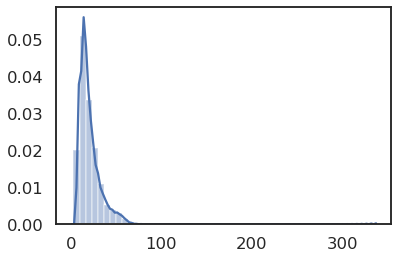

In [27]:
# First load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokens = regular_encode(train_df['review'].values, tokenizer, pad_max=False)

token_length = [len(token) for token in tokens]
sns.distplot(token_length);

# Pecentiles of token lengths
np.percentile(token_length, [0.5, 1, 5, 25, 50, 75, 90, 99, 99.5])

In [28]:
# Setting MAX_LEN to > 99% percentile
MAX_LEN = 64

## Model

In [29]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    sequence_output = transformer(input_word_ids)[0]
    # Take only the first token of the sequence output because it contains the CLS token which encodes the meaning of the entire review
    cls_token = sequence_output[:, 0, :]
    out = Dense(NUM_CLASSES, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [30]:
def get_model():
    print('Loading pretrained model...')
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(MODEL)
        model = build_model(transformer_layer, max_len=MAX_LEN)
        print('LOADED.')
    return model

In [31]:
# For debugging purposes
if DEBUG:
    train_df = train_df.sample(10000)
    test_df = test_df.sample(5000)

# Convert rating from 0 to 4
train_df['rating'] = train_df['rating'] - 1
# Convert reviews to arrays
X, Y = train_df['review'].values, train_df['rating'].values

In [32]:
# Encode test reviews
x_test = regular_encode(test_df['review'].values, tokenizer, maxlen=MAX_LEN)

# Convert test reviews array to tensorflow dataset 
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# Calculate number of steps needed, +1 because the last step has leftover samples due to flooring
n_steps_test = (x_test.shape[0] // BATCH_SIZE) + 1

In [33]:
# To store test probabilities for each fold
test_folds_dfs = []

# Training for k number of splits
def train_kfold(folds):
    # Using StratifiedShuffleSplit because the rating 1 and 2 are too few to do k-folds
    sss = StratifiedShuffleSplit(n_splits=folds, test_size=0.1, random_state=RANDOM_SEED)
    # Loop for each fold
    for fold, (trn_ind, val_ind) in enumerate(sss.split(X, Y)):
        
        tf.tpu.experimental.initialize_tpu_system(tpu)
        
        checkpoint_filepath = 'model.h5'
        checkpointCallback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                                save_weights_only=True, 
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)

        earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)

        reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)
        
        print('Starting fold {}...'.format(fold))
        X_train, X_valid = X[trn_ind], X[val_ind]
        Y_train, Y_valid = Y[trn_ind], Y[val_ind]
        
        # Unique classes
        classes = np.unique(train_df['rating'])
        
        # Calculate weight for each label since label are imbalanced
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
        class_weight = dict(enumerate(weights))
        
        # Encode reviews
        x_train = regular_encode(X_train, tokenizer, maxlen=MAX_LEN)
        x_valid = regular_encode(X_valid, tokenizer, maxlen=MAX_LEN)
        
        # Convert ratings to one-hot-encoding vector
        y_train = to_categorical(Y_train, NUM_CLASSES)
        y_valid = to_categorical(Y_valid, NUM_CLASSES)
        
        # Convert training data to tensorflow dataset
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((x_train, y_train))
            .repeat()
            .shuffle(RANDOM_SEED)
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )
        
        # Convert validation data to tensorflow dataset
        valid_dataset = (
            tf.data.Dataset
            .from_tensor_slices((x_valid, y_valid))
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(AUTO)
        )
        
        # Calculate number of steps needed 
        n_steps_train = x_train.shape[0] // BATCH_SIZE
        n_steps_valid = x_valid.shape[0] // BATCH_SIZE
        
        model = get_model()
        
        print('Begin training fold {}...'.format(fold))
        history = model.fit(train_dataset, 
                          steps_per_epoch=n_steps_train, 
                          epochs=EPOCHS,
                          validation_data=valid_dataset, 
                          validation_steps=n_steps_valid,
                          verbose=1,
                          class_weight=class_weight,
                          callbacks=[PrintSystemLogPerEpoch(), checkpointCallback, earlyStop, reduceLR])
        
        model.load_weights(checkpoint_filepath)
        
        prob = model.predict(test_dataset, steps = n_steps_test)
        
        kaggle = test_df[['review_id']]

        for i in range(NUM_CLASSES):
            kaggle['probability_{}'.format(i)] = prob[:, i]
        
        test_folds_dfs.append(kaggle)
#         kaggle.to_csv('probabilities_fold_{}.csv'.format(fold), index=False)
        print('Saved fold {}...'.format(fold))
        print('')

In [34]:
train_kfold(folds=1)

Starting fold 0...
Loading pretrained model...



LOADED.
Begin training fold 0...
* [Epoch 1] begins at 10:10:18.713438
Epoch 1/6
1410/1410 [==============================] - ETA: 0s - accuracy: 0.5945 - loss: 1.1633
* [Epoch 1] ends at 10:25:49.152763 | loss=1.1633, val_loss=0.7886
1410/1410 [==============================] - 806s 571ms/step - accuracy: 0.5945 - loss: 1.1633 - val_accuracy: 0.6813 - val_loss: 0.7886 - lr: 1.0000e-05
* [Epoch 2] begins at 10:25:58.168638
Epoch 2/6
1410/1410 [==============================] - ETA: 0s - accuracy: 0.6660 - loss: 1.0262
* [Epoch 2] ends at 10:38:50.891128 | loss=1.0262, val_loss=0.7674
1410/1410 [==============================] - 781s 554ms/step - accuracy: 0.6660 - loss: 1.0262 - val_accuracy: 0.6955 - val_loss: 0.7674 - lr: 1.0000e-05
* [Epoch 3] begins at 10:38:59.798118
Epoch 3/6
1410/1410 [==============================] - ETA: 0s - accuracy: 0.6778 - loss: 0.9871
* [Epoch 3] ends at 10:51:52.766635 | loss=0.9871, val_loss=0.7648
1410/1410 [==============================] - 781s 55

In [35]:
# Stack the dataframes vertically
test_ensembles = pd.concat(test_folds_dfs, axis=0)
# Take the mean probabilites for each review
mean_probabilities = test_ensembles.groupby('review_id').mean()
# Convert probabilities to predictions and add 1 to convert ratings from 0-4 to 1-5
predictions = np.argmax(mean_probabilities.values, axis=1) + 1
# Kaggle submission
submission = test_df[['review_id']].copy()
submission['rating'] = predictions
submission.to_csv('submission.csv', index=False)